In [11]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import glob
import os
import math
import matplotlib
from matplotlib import pyplot as plt, dates
import scipy
from scipy import optimize
import sklearn
import requests
from io import StringIO
import sys
import csv   
from csv import writer
import time
import shutil
import pickle
import seaborn as sns

In [2]:
def my_callback_function(state):      
    global low_limit, high_limit,hot_complaint,cold_complaint
    envNum = api.exchange.current_environment_num(state)
    if envNum == 3: # if sizing done 
        tSetHtg_hndl = api.exchange.get_actuator_handle(state, "Schedule:Constant", "Schedule Value", "tSetHtg")
        tSetClg_hndl = api.exchange.get_actuator_handle(state, "Schedule:Constant", "Schedule Value", "tSetClg")
        tIn_office_hndl = api.exchange.get_variable_handle(state,"Zone Mean Air Temperature","Office")
        tIn_lobby_hndl = api.exchange.get_variable_handle(state,"Zone Mean Air Temperature","Lobby")
        htg_hndl = api.exchange.get_meter_handle(state,"Heating:Electricity")
        clg_hndl = api.exchange.get_meter_handle(state,"Cooling:Electricity")

        # exchange information with EnergyPlus
        month = api.exchange.month(state) 
        time_of_day = api.exchange.hour(state)
        day_of_week = api.exchange.day_of_week(state)
        tIn_office = api.exchange.get_variable_value(state,tIn_office_hndl)
        tIn_lobby = api.exchange.get_variable_value(state,tIn_lobby_hndl)
        heating_meter_reading = api.exchange.get_meter_value(state,htg_hndl)
        cooling_meter_reading = api.exchange.get_meter_value(state,clg_hndl)

        ## occupant complaint model
        cold_complaint = 0
        hot_complaint = 0 
        if (time_of_day > 8) and (time_of_day < 17) and (day_of_week > 1): # occupied periods
            if (tIn_office < low_limit) or (tIn_lobby < low_limit):
                cold_complaint = 1
            elif (tIn_office > high_limit) or (tIn_lobby > high_limit):
                hot_complaint = 1
        
        ## actuate DLC parameters
        api.exchange.set_actuator_value(state, tSetHtg_hndl, 18)
        api.exchange.set_actuator_value(state, tSetClg_hndl, 27)


        # bank operates on weekdays and on Saturdays
        if (day_of_week > 1):
            if (time_of_day > 7 and time_of_day < 17):
                api.exchange.set_actuator_value(state, tSetHtg_hndl, 21)
                api.exchange.set_actuator_value(state, tSetClg_hndl, 24)

        # time of use rates apply to weekdays only
        if ((month > 10) or (month < 5)) and (day_of_week > 1 and day_of_week < 7):
            if (time_of_day > 7 - ph_dur) and (time_of_day < 7): # preheat winter off-peak
                api.exchange.set_actuator_value(state, tSetHtg_hndl, 18 + ph_mag)
            if (time_of_day >= 7) and (time_of_day < 11): # setback winter on-peak
                api.exchange.set_actuator_value(state, tSetHtg_hndl, 21 - sb_mag)

        if ((month > 4) and (month < 11)) and (day_of_week > 1 and day_of_week < 7):
            if (time_of_day > 7 - pc1_dur) and (time_of_day < 7): # precool summer off-peak
                api.exchange.set_actuator_value(state, tSetClg_hndl, 27 - pc1_mag)
            if (time_of_day >= 7) and (time_of_day < 11 - pc2_dur): # setup summer mid-peak
                api.exchange.set_actuator_value(state, tSetClg_hndl, 24 + su1_mag)
            if (time_of_day >= 11 - pc2_dur) and (time_of_day < 11): # precool summer mid-peak
                api.exchange.set_actuator_value(state, tSetClg_hndl, 24 - pc2_mag)
            if (time_of_day >= 11) and (time_of_day <= 17): # setup summer on-peak
                api.exchange.set_actuator_value(state, tSetClg_hndl, 24 + su2_mag)

        # rate calculator
        cost = ((heating_meter_reading + cooling_meter_reading)/1000000*0.278)*8.7/100
        if ((month > 10) or (month < 5)) and (day_of_week > 1 and day_of_week < 7):
            if (time_of_day > 7) and (time_of_day <= 11):
                cost = ((heating_meter_reading + cooling_meter_reading)/1000000*0.278)*18.2/100
            elif (time_of_day > 11) and (time_of_day <= 17):
                cost = ((heating_meter_reading + cooling_meter_reading)/1000000*0.278)*12.2/100
            elif (time_of_day > 17) and (time_of_day < 19): 
                cost = ((heating_meter_reading + cooling_meter_reading)/1000000*0.278)*18.2/100

        if ((month > 4) and (month < 11)) and (day_of_week > 1 and day_of_week < 7):
            if (time_of_day > 7) and (time_of_day <= 11):
                cost = ((heating_meter_reading + cooling_meter_reading)/1000000*0.278)*12.2/100
            elif (time_of_day > 11) and (time_of_day <= 17):
                cost = ((heating_meter_reading + cooling_meter_reading)/1000000*0.278)*18.2/100
            elif (time_of_day > 17) and (time_of_day < 19): 
                cost = ((heating_meter_reading + cooling_meter_reading)/1000000*0.278)*12.2/100
                
        electricity.append(cost) 
        discomfort.append(cold_complaint + hot_complaint)

In [3]:
counter = 0

def wrapper(parameters):
    global counter,ph_mag,ph_dur,sb_mag, pc1_mag, pc1_dur, su1_mag, pc2_mag, pc2_dur, su2_mag, api, electricity, discomfort, low_limit, high_limit, state
    
    electricity = []
    discomfort = []
    low_limit = 20 # complaint limits
    high_limit = 26 # complaint limits
    
    ph_mag = parameters[0]
    ph_dur = parameters[1]
    sb_mag = parameters[2]
    
    pc1_mag = parameters[3]
    pc1_dur = parameters[4]
    su1_mag = parameters[5]
    
    pc2_mag = parameters[6]
    pc2_dur = parameters[7]
    su2_mag = parameters[8]  
              
    sys.path.insert(0, 'C:\EnergyPlusV23-1-0')  # add E-Plus directory to path to be able to import API
    from pyenergyplus.api import EnergyPlusAPI #import EnergyPlus library
    api = EnergyPlusAPI()
    state = api.state_manager.new_state() 
    api.runtime.clear_callbacks()
    api.functional.clear_callbacks()
    
    # energyplus model calling point, callback function
    api.runtime.callback_begin_system_timestep_before_predictor(state,my_callback_function)
    # run EPlus
    epwFile = 'CAN_ON_TORONTO-INTL-A_6158731_CWEC.epw'
    idfFile = 'normal_normal.idf'
    # -x short form to run expandobjects for HVACtemplates. see EnergyPlusEssentials.pdf p16
    cmd_args = ['-w',epwFile, '-d', 'out','-x',idfFile]
    api.runtime.run_energyplus(state,cmd_args)

    api.state_manager.delete_state(state)

    counter = counter + 1
    print(counter)
    
#     obj = sum(electricity) + sum(electricity)*(sum(discomfort) > 1000)
    obj = sum(electricity) + sum(electricity)*(((sum(discomfort)/len(discomfort))*10)**2)

    with open('document.csv', 'a') as f_object:
        writer_object = writer(f_object)
        writer_object.writerow([sum(electricity),sum(discomfort)/4, obj, ph_mag,ph_dur,sb_mag, pc1_mag, pc1_dur, su1_mag, pc2_mag, pc2_dur, su2_mag])
        f_object.close()
    return obj

In [4]:
start = time.time()
scenarios_info = pd.read_excel('scenarios_def_opt.xlsx')
active_cases = scenarios_info[scenarios_info.active == 1]
bounds = [[0,6],[0,3],[0,3],[0,6],[0,3],[0,3],[0,3],[0,3],[0,3]] 
for i, row in active_cases.iterrows():
    
    idf_file = "Models_heatpump/"+row.idf_file
    epw_file = row.epw_file
    output_dir = "Results/Scenario_{}".format(row.ID)
    [low_limit, high_limit] = eval(row.comfort_range)
    results = scipy.optimize.differential_evolution(wrapper,bounds,maxiter=6, popsize=8, polish=False)
    # save results
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    shutil.copy("out/eplusout.csv", output_dir+"/eplusout.csv")
    shutil.copy("document.csv", output_dir+"/document.csv")
    # save results variable: the output of optimization
    with open(output_dir+"/opt_results.pkl", 'wb') as file:
        pickle.dump(results, file) 
    # erase document after copying
    os.remove("document.csv")
end = time.time()
print((end - start)/3600)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


In [ ]:
df = pd.read_csv("document.csv",names=["elect","discomfort","objective","ph_mag","ph_dur","sb_mag", "pc1_mag", "pc1_dur", "su1_mag", "pc2_mag", "pc2_dur", "su2_mag"])
plt.plot(df["ph_dur"])

In [ ]:
parameters = results.x

ph_mag = parameters[0]
ph_dur = parameters[1]
sb_mag = parameters[2]

pc1_mag = parameters[3]
pc1_dur = parameters[4]
su1_mag = parameters[5]

pc2_mag = parameters[6]
pc2_dur = parameters[7]
su2_mag = parameters[8]    

electricity = []
discomfort = []
low_limit = 20 # complaint limits
high_limit = 26 # complaint limits

state = api.state_manager.new_state() 
# energyplus model calling point, callback function
api.runtime.callback_begin_system_timestep_before_predictor(state,my_callback_function)
# run EPlus
epwFile = 'CAN_ON_TORONTO-INTL-A_6158731_CWEC.epw'
idfFile = 'normal_normal.idf'
# -x short form to run expandobjects for HVACtemplates. see EnergyPlusEssentials.pdf p16
cmd_args = ['-w',epwFile, '-d', 'out','-x',idfFile]
api.runtime.run_energyplus(state,cmd_args)

electricity_cost = sum(electricity)
discomfort_cost = sum(discomfort)/4

df = pd.DataFrame([idfFile,electricity_cost,discomfort_cost,ph_mag,ph_dur,sb_mag,pc1_mag,pc1_dur,su1_mag,pc2_mag,pc2_dur,su2_mag])
df = df.transpose()

currentDir = os.getcwd()
df.to_csv(currentDir + '\\output.csv', mode='a', index = False, header=None)

C:\Users\Hussein Elehwany\AppData\Local\Temp\ipykernel_37696\4088969418.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(6,3))


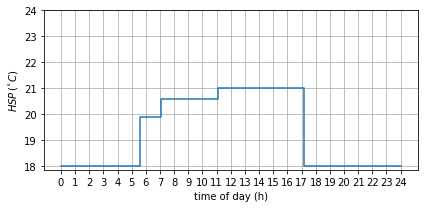

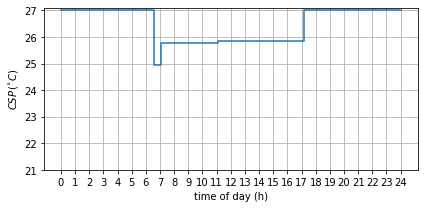

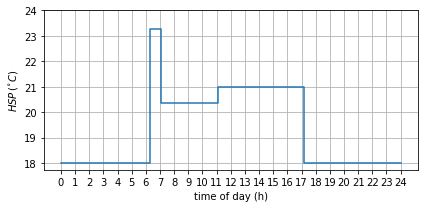

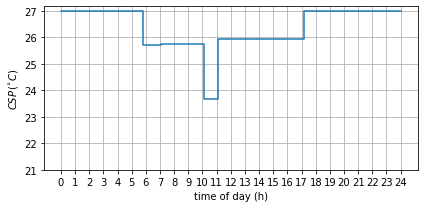

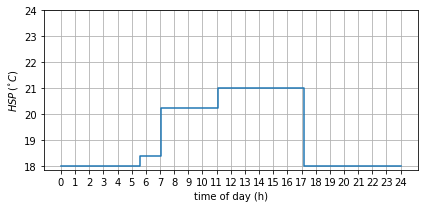

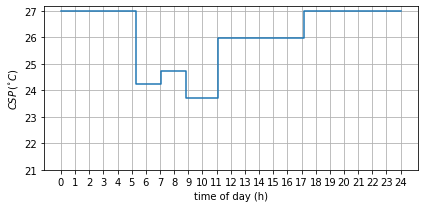

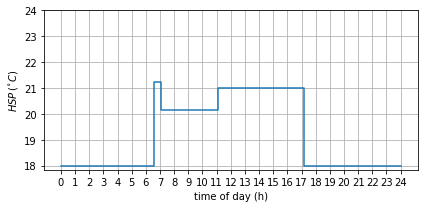

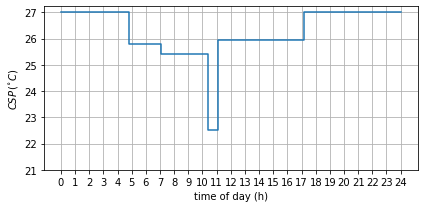

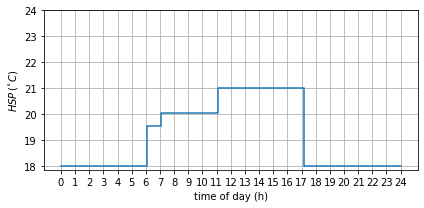

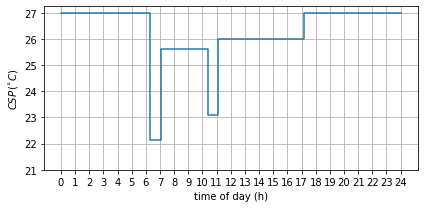

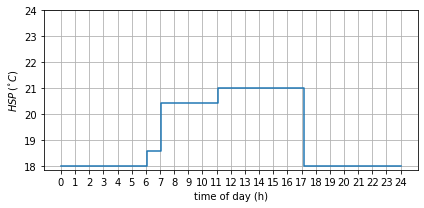

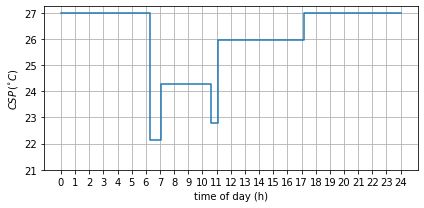

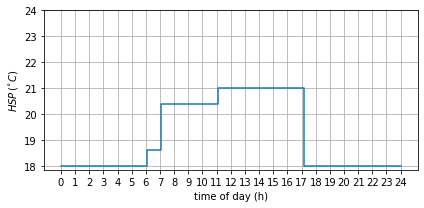

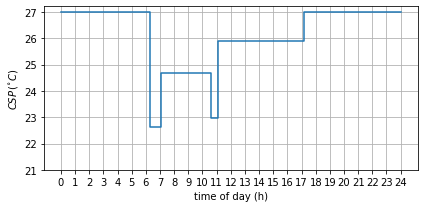

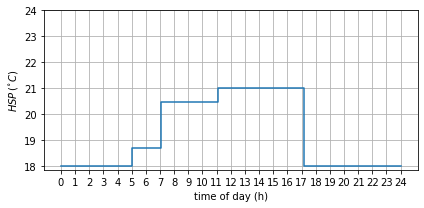

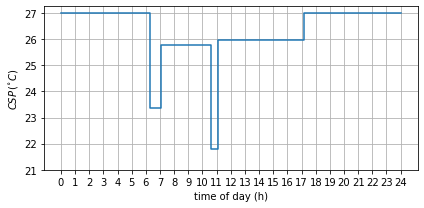

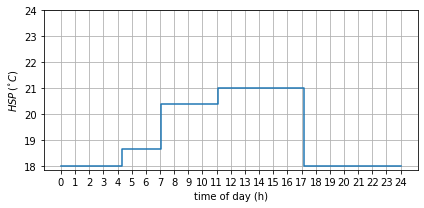

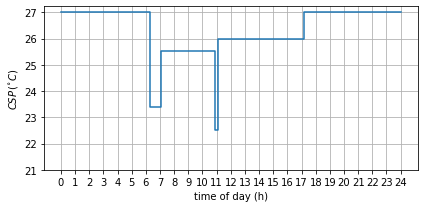

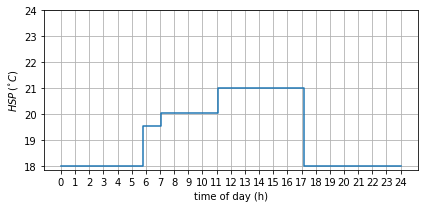

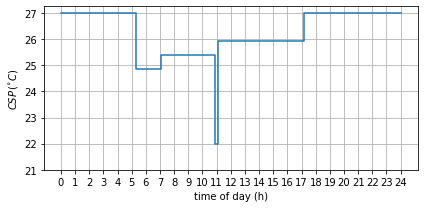

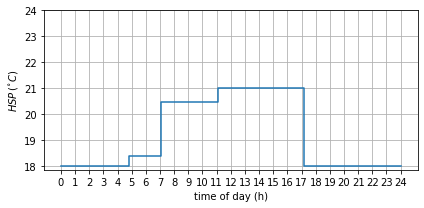

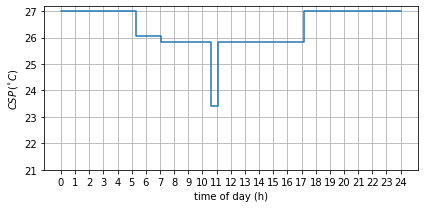

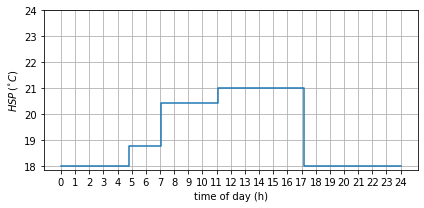

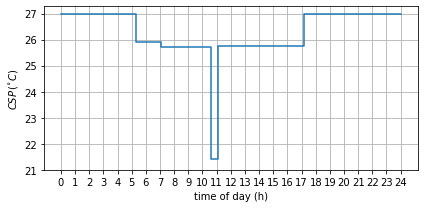

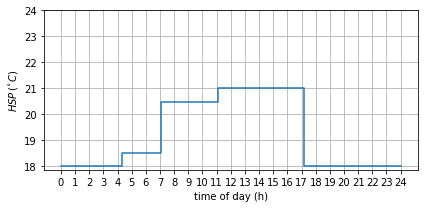

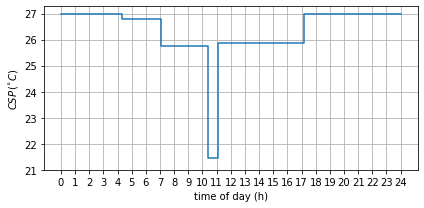

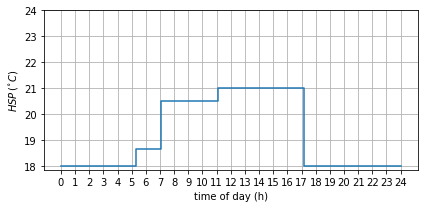

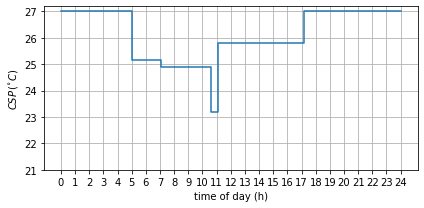

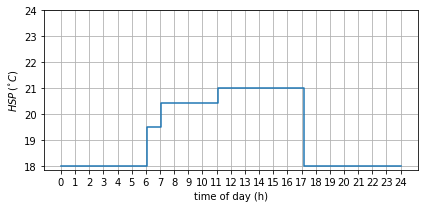

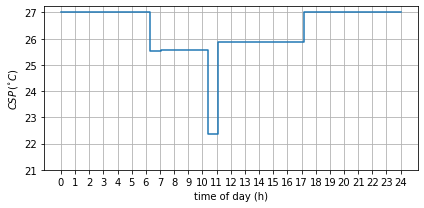

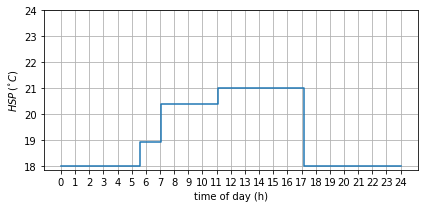

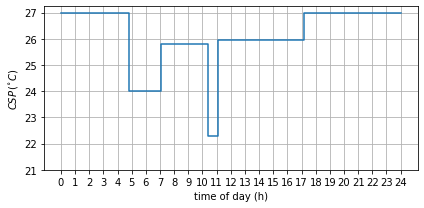

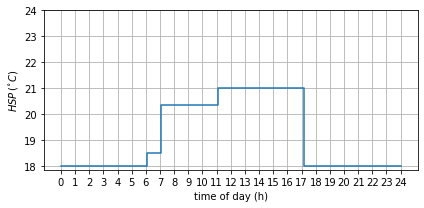

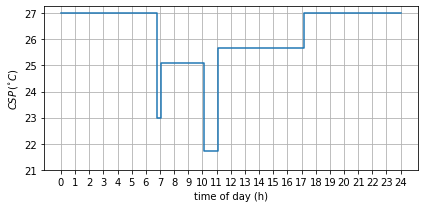

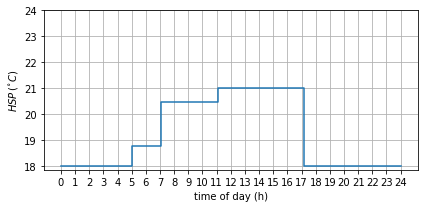

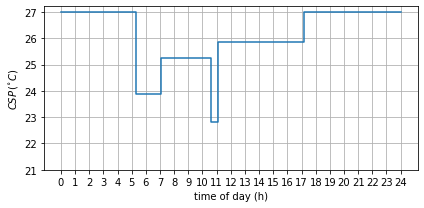

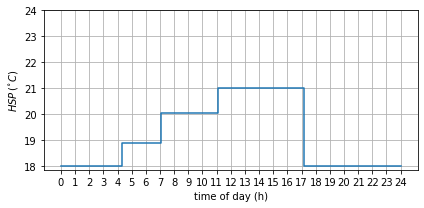

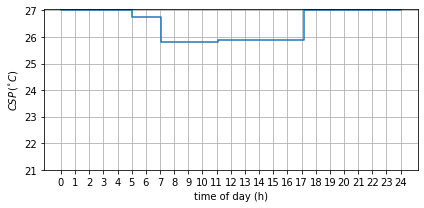

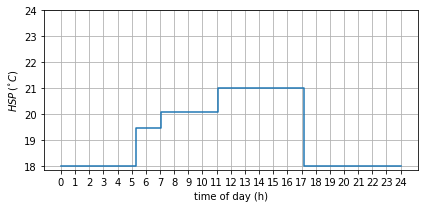

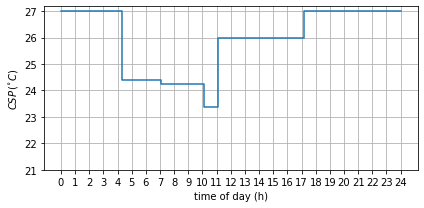

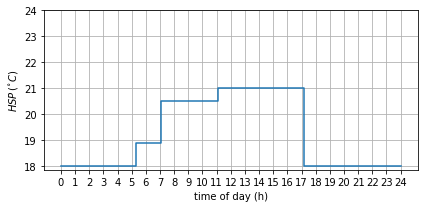

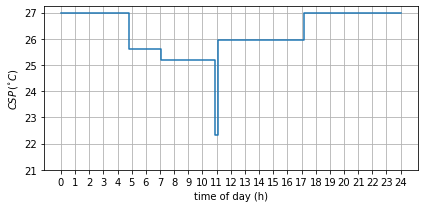

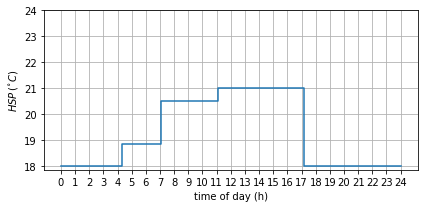

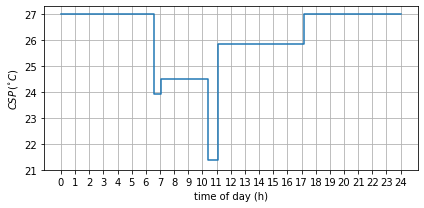

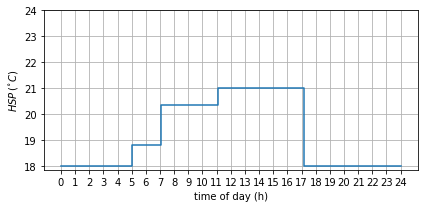

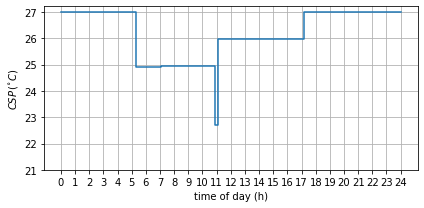

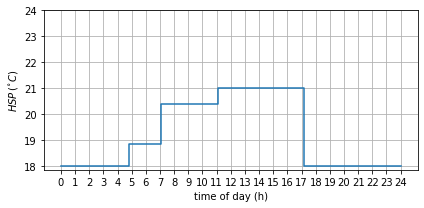

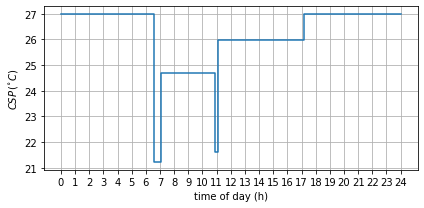

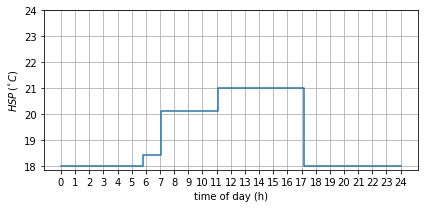

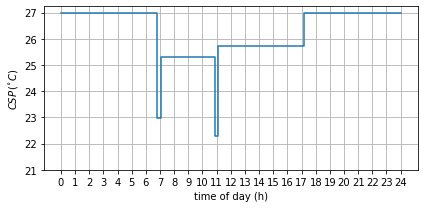

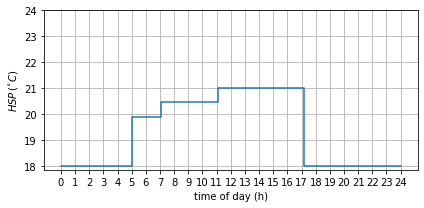

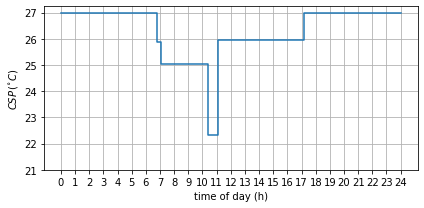

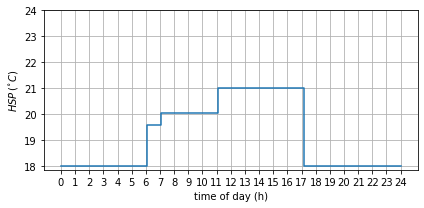

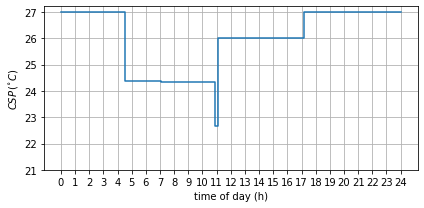

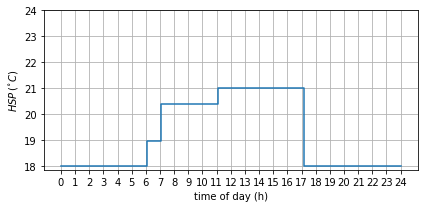

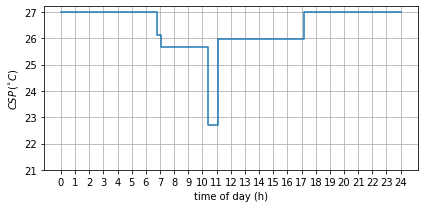

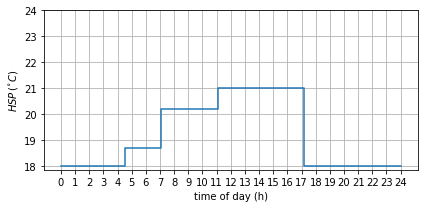

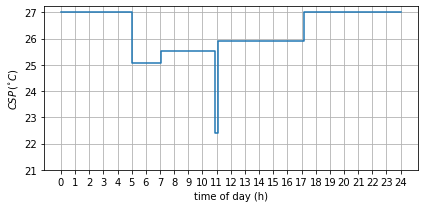

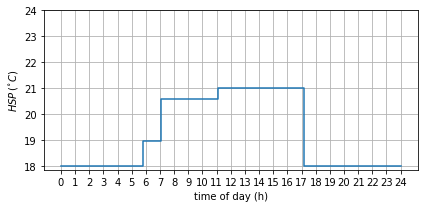

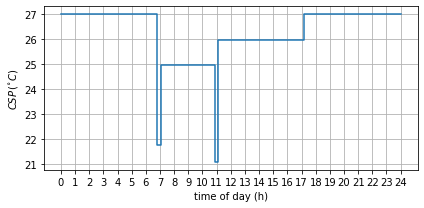

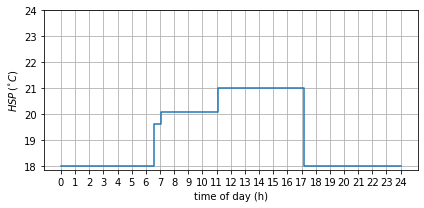

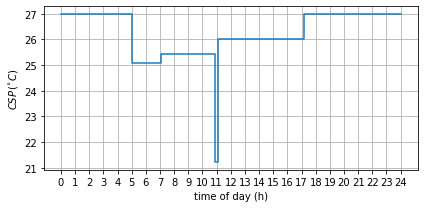

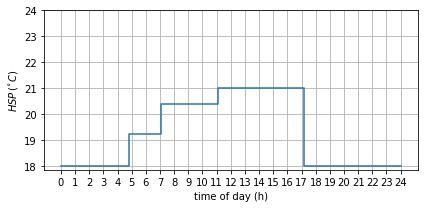

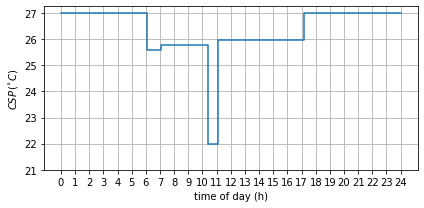

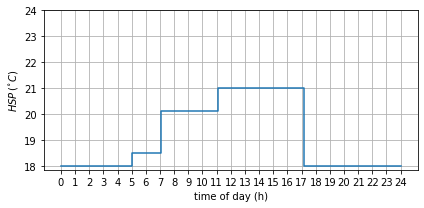

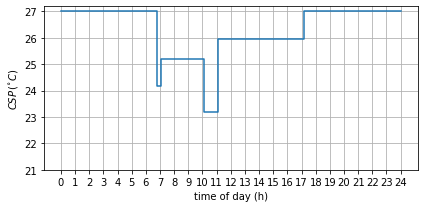

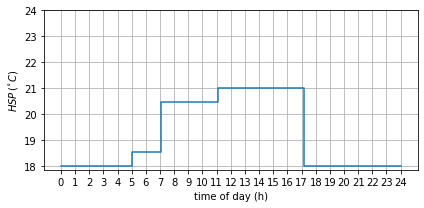

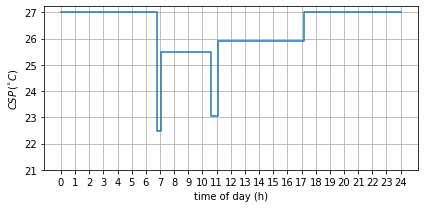

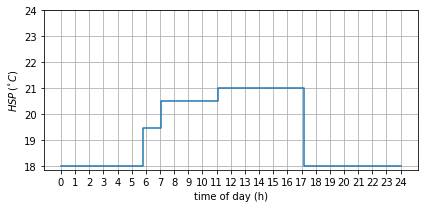

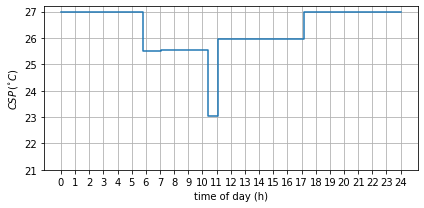

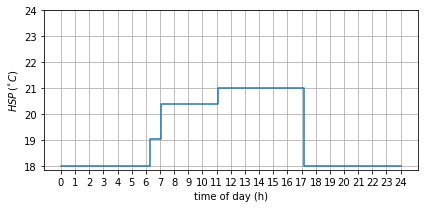

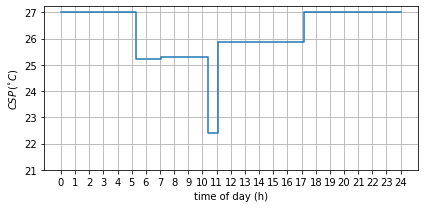

In [18]:
for case in range(1,37):
    with open('Results\Scenario_{}\opt_results.pkl'.format(case), 'rb') as f:
        results = pickle.load(f)

    day_of_week = range(1,8)
    time_of_day = np.linspace(0,24,96)
    month = 1

    initializer_coeff_precond = 2 # preconditioning parameter multipliers
    initializer_coeff_sb_su = 2 # setup/setback parameter multipliers

    ph_mag = results.x[0]
    ph_dur = results.x[1]
    sb_mag = results.x[2]

    pc1_mag = results.x[3]
    pc1_dur = results.x[4]
    su1_mag = results.x[5]

    pc2_mag = results.x[6]
    pc2_dur = results.x[7]
    su2_mag = results.x[8]

    store_hsp = []
    store_csp = []

    for i in range(1,2):
        for j in range(96):
            hsp = 18
            if (day_of_week[i] > 1):
                if (time_of_day[j] > 7 and time_of_day[j] < 17):
                    hsp = 21
            if ((month > 10) or (month < 5)) and (day_of_week[i] > 1 and day_of_week[i] < 7):
                if (time_of_day[j] > 7 - ph_dur) and (time_of_day[j] < 7): # preheat winter off-peak
                    hsp = 18 + ph_mag
                if (time_of_day[j] >= 7) and (time_of_day[j] < 11): # setback winter on-peak
                    hsp = 21 - sb_mag
            store_hsp.append(hsp)

    store_hsp = pd.DataFrame(store_hsp)
    fig, ax = plt.subplots(figsize=(6,3))
    ax.step(time_of_day,store_hsp,where='post');
    ax.set(xlabel='time of day (h)', ylabel='$HSP \, (^{\circ}C)$')
    plt.xticks(np.arange(0, 25, 1))
    plt.yticks(np.arange(18, 25, 1))
    ax.grid()
    plt.tight_layout()
    plt.savefig('Results\\Scenario_{}\\normal_normal_hsp.jpg'.format(case), dpi=300, bbox_inches='tight');

    month = 5

    for i in range(1,2):
        for j in range(96):
            csp = 27
            if (day_of_week[i] > 1):
                if (time_of_day[j] > 7 and time_of_day[j] < 17):
                    csp = 24
            if ((month > 4) and (month < 11)) and (day_of_week[i] > 1 and day_of_week[i] < 7):
                if (time_of_day[j] > 7 - pc1_dur) and (time_of_day[j] < 7): # precool summer off-peak
                    csp = 27 - pc1_mag
                if (time_of_day[j] >= 7) and (time_of_day[j] < 11 - pc2_dur): # setup summer mid-peak
                    csp = 24 + su1_mag
                if (time_of_day[j] >= 11 - pc2_dur) and (time_of_day[j] < 11): # precool summer mid-peak
                    csp = 24 - pc2_mag
                if (time_of_day[j] >= 11) and (time_of_day[j] <= 17): # setup summer on-peak
                    csp = 24 + su2_mag

            store_csp.append(csp)        

    store_csp = pd.DataFrame(store_csp)
    fig, ax = plt.subplots(figsize=(6,3))
    ax.step(time_of_day,store_csp,where='post');
    plt.xticks(np.arange(0, 25, 1))
    plt.yticks(np.arange(21, 28, 1))
    ax.set(xlabel='time of day (h)', ylabel='$CSP \, (^{\circ}C)$')
    ax.grid()
    plt.tight_layout()
    plt.savefig('Results\\Scenario_{}\\normal_normal_csp.jpg'.format(case), dpi=300, bbox_inches='tight');

# Plot results

In [ ]:
case_no = 9
var_iter = 7
var_pop = 8*9
df = pd.read_csv("Results/Scenario_{}/document.csv".format(case_no))
pop_list = []
for i in range(var_iter):
    pop_list.append(df["objective"][i*var_pop:(i+1)*var_pop].values)
df_box = pd.DataFrame(pop_list).transpose()
sns.boxplot(df_box).set(xlabel="Iterations", ylabel="objective")